# Reinforcement Learning - HW 2

## by Clarice Mottet

0. **[Part 0: Set Up](#part0)**
- **Objective**: Initialize programming environment.
- **Tasks:**
    - Set up libraries
    - Initialize global variables
    - Create functions to be used throughout notebook base on problem set up

1. **[Part 1: Approximate Policy Evaluation](#part1)**
- **Objective**: Study the performance of simple policies using TD(0) and LSTD
- **Tasks:**
  - TD(0) algorithm creation and plot example
  - LSTD algorithm creation and plot example
  - Plot Lazy Policy value function results by
      - max_iter ($10^4, 10^5, 10^6, 10^7$)
      - method (TD(0), LSTD(0): [fine, coarse, piecewise])
  - Plot Aggressive Policy value function results by
      - max_iter ($10^4, 10^5, 10^6, 10^7$)
      - method (TD(0), LSTD(0): [fine, coarse, piecewise])
  - Compare difference betweeh Lazy and Aggressive Policy value function results by
      - max_iter ($10^4, 10^5, 10^6, 10^7$)
      - method (TD(0), LSTD(0): [fine, coarse, piecewise])
  - Compare to results from HW1 by incorporating the below into the plot
    - Value function under lazy policy
    - Value function under aggressive policy
    - Value function from policy iteration[100]

2. **[Part 2: Approximate Policy Iteration](#part2)**
- **Objective**: implement an approximate policy iteration method
- **Tasks:**
  - Create approximate policy iteration method
  - Plot value function after 10 and 100 iterations and compare to value function from Part1
  - Compare the value function to the optimal value function from HW1
  - Plot the service rates assigned by the final policy, interpret

## <a id='part0'>Part 0: Set Up</a>
- **Objective**: Initialize programming environment.
- **Tasks:**
    - Set up libraries
    - Initialize global variables
    - Create functions to be used throughout notebook base on problem set up

- Set up libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import time


/home/clarice/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


- Initialize global variables

In [2]:
N_MAX = 100
GAMMA = 0.9

Q_LOW = 0.51
Q_HIGH = 0.6

COST_LOW = 0.0
COST_HIGH = 0.01

ARRIVAL_RATE = 0.5

ACTION_LIST = [0, 1] #action_ind (low = 0, high = 1)

MAX_ITER_LIST = [10e4, 10e5, 10e6, 10e7]
MAX_ITER_LIST_STR = ['10e4', '10e5', '10e6', '10e7']

#step size parameters for alpha_t = (A/t+B) in TD(0)
A_step = 10e5
B_step = 10e5


- Create functions to be used throughout notebook base on problem set up
    - reward functions
    - transition functions
    - evaluation functions
    - simulation functions
    - feature maps
    - policy functions from hw1
    - value iteration and policy iteration from hw1

In [3]:
#reward functions

def action_cost(action_ind):
    if action_ind == 0:
        return COST_LOW
    else:
        return COST_HIGH

def reward_calc(x, action_ind):
    return -((x/N_MAX)**2) - action_cost(action_ind)

def reward_under_policy(pi):
    r_pi = np.zeros(N_MAX)
    for x in range(0, N_MAX):
        # action_ind = None
        for a in ACTION_LIST:
            r_pi[x] += reward_calc(x, a)*pi[x,a]
    return r_pi


In [4]:
#transitions functions

def reduction_rate(action_ind):
    if action_ind == 0:
        return Q_LOW
    else:
        return Q_HIGH
    
def transition_framework():
    #conditional matrix P(x, x_prime, a)
    P = np.zeros((N_MAX,N_MAX,2))
    for x in range(0,N_MAX):
        for a in ACTION_LIST:
            if x == 0:
                P[x, 0, a] = (1-ARRIVAL_RATE) + (reduction_rate(a))*(ARRIVAL_RATE)
                P[x, 1, a] = (reduction_rate(a))*(1-ARRIVAL_RATE)
            elif x == (N_MAX-1):
                P[x, N_MAX-2, a] = (reduction_rate(a))*(1-ARRIVAL_RATE)
                P[x, N_MAX-1, a] = (1-reduction_rate(a)) + (reduction_rate(a))*(ARRIVAL_RATE)
            else:
                #(decrement, increment)
                for x_prime in [x-1, x, x+1]:
                    if x_prime == (x-1):
                        #(1,0)
                        P[x, x_prime, a] = (reduction_rate(a))*(1-ARRIVAL_RATE)
                    if x_prime == x:
                        #(0,0) + (1,1)
                        P[x, x_prime, a] = (1-reduction_rate(a))*(1-ARRIVAL_RATE) + (reduction_rate(a))*(ARRIVAL_RATE)
                    if x_prime == (x+1):
                        #(0,1)
                        P[x, x_prime, a] = (1-reduction_rate(a))*(ARRIVAL_RATE)
    return P

def transition_under_policy(pi):
    P = transition_framework()

    #create transition matrix based on policy P(x, x_prime)
    P_pi = np.zeros((N_MAX,N_MAX))
    for x in range(N_MAX):
        for x_prime in [x-1, x, x+1]:
            if (x_prime < N_MAX) and (x_prime >= 0):
                for a in ACTION_LIST:
                    P_pi[x,x_prime] += P[x,x_prime,a]*pi[x,a]
    return P_pi


In [5]:
#evaluation functions

def value_under_policy(pi):
    P = transition_framework()
    r = reward_under_policy(pi)

    X = np.size(P,1)
    V_pi = np.zeros((X))

    P_pi = transition_under_policy(pi)
    V_pi = np.linalg.inv(np.eye(X) - GAMMA*P_pi).dot(r)
    return V_pi


In [6]:
#simulation functions

def next_state(state_val, action_ind):
    increment_t = random.choices([0, 1], weights=[1-ARRIVAL_RATE, ARRIVAL_RATE])[0]
    decrement_t = random.choices([0, 1], weights=[1-reduction_rate(action_ind), reduction_rate(action_ind)])[0]
    net_t = increment_t - decrement_t
    return min(N_MAX-1, max(state_val + net_t, 0))

def plot_results(data, x_title, y_title, title, color):
    plt.figure(figsize=(5, 3))
    plt.plot(data, linestyle = 'dotted', color = color)
    plt.xlabel(x_title)
    plt.ylabel(y_title)
    plt.title(title)
    plt.show()


In [7]:
#feature maps

def fine_feature_map(x):
    phi = np.zeros(N_MAX)
    phi[x] = 1
    return phi

def coarse_feature_map(x):
    phi = np.zeros(int(N_MAX/5))
    for i in range(int(N_MAX/5)):
        if x in range(int(5*i),int(5*i)+5):
            phi[i] = 1
    return phi

def piecewise_feature_map(x):
    phi = np.zeros((int((N_MAX/5))*2))

    phi_coarse = coarse_feature_map(x)
    for i in range(int(N_MAX/5)):
        phi[i] = phi_coarse[i]
        if phi[i] == 1:
            phi[i+int(N_MAX/5)] = phi[i]*((x - 5*i)/5)
    return phi


In [8]:
#policies

def policy_lazy():
    pi = np.zeros((N_MAX,2))
    for x in range(0,N_MAX):
        pi[x, 0] = 1 #action_ind (low = 0, high = 1)
        pi[x, 1] = 0
    return pi

def policy_aggr():
    pi = np.zeros((N_MAX,2))
    for x in range(0,N_MAX):
        if x < 50:
            pi[x, 0] = 1 #action_ind (low = 0, high = 1)
            pi[x, 1] = 0
        else:
            pi[x, 0] = 0 
            pi[x, 1] = 1 #action_ind (low = 0, high = 1)
    return pi


In [9]:
#HW1 functions

def value_iteration(max_iter):
    #initialize frameworks 
    P = transition_framework()
    r = np.zeros((N_MAX, 2))
    for x in range(N_MAX):
        for a in ACTION_LIST:
            r[x,a] = reward_calc(x,a)

    #initialize value function
    V = np.zeros((N_MAX, 1))

    #value iteration
    for k in range(max_iter):
        V_star = -np.inf
        for a in range(2):
            V_star = np.maximum(V_star, r[:, a].reshape([-1, 1]) + GAMMA* P[:, :, a].dot(V))
        V = V_star
    
    return V.flatten()

def policy_iteration(max_iter):

    #initialize frameworks
    P = transition_framework()
    pi_star = policy_aggr()

    #policy iteration
    for k in range(max_iter):

        V_new = value_under_policy(pi_star)

        V_max = np.zeros((N_MAX,2))
        for x in range(N_MAX):
            for a in ACTION_LIST:
                V_max[x,a] = reward_calc(x,a) + GAMMA*P[x, :, a].dot(V_new)

        pi_star = np.eye(V_max.shape[1])[np.argmax(V_max, axis=1)]

    return value_under_policy(pi_star), pi_star


## <a id='part1'>Part 1: Approximate Policy Evaluation</a>
- **Objective**: Study the performance of simple policies using TD(0) and LSTD
- **Tasks:**
  - TD(0) algorithm creation and plot example
  - LSTD algorithm creation and plot example
  - Plot Lazy Policy value function results by
      - max_iter ($10^4, 10^5, 10^6, 10^7$)
      - method (TD(0), LSTD(0): [fine, coarse, piecewise])
  - Plot Aggressive Policy value function results by
      - max_iter ($10^4, 10^5, 10^6, 10^7$)
      - method (TD(0), LSTD(0): [fine, coarse, piecewise])
  - Compare difference betweeh Lazy and Aggressive Policy value function results by
      - max_iter ($10^4, 10^5, 10^6, 10^7$)
      - method (TD(0), LSTD(0): [fine, coarse, piecewise])
  - Compare to results from HW1 by incorporating the below into the plot
    - Value function under lazy policy
    - Value function under aggressive policy
    - Value function from policy iteration[100]

- TD(0) algorithm creation and plot example

In [10]:
#TD(O) algorithm

def td_zero(x_init, pi, max_iter):

    #initialize
    V_t = value_under_policy(pi)
    V_tpo = V_t

    x_t = x_init
    a_t = np.argmax(pi[x_t])
    x_tpo = next_state(x_t, a_t)
    track_x_t = []
    track_x_t.append(x_t)

    #run iterations
    for t in range(int(max_iter)):
        alpha_t = (A_step/(t+B_step))
        delta_t = reward_calc(x_t, a_t) + GAMMA*V_t[x_tpo] - V_t[x_t]

        V_tpo[x_t] = V_t[x_t] + alpha_t*delta_t

        V_t = V_tpo
        x_t = x_tpo
        a_t = np.argmax(pi[x_t])
        x_tpo = next_state(x_t, a_t)
        track_x_t.append(x_t)

    return V_t, track_x_t


min state: 0


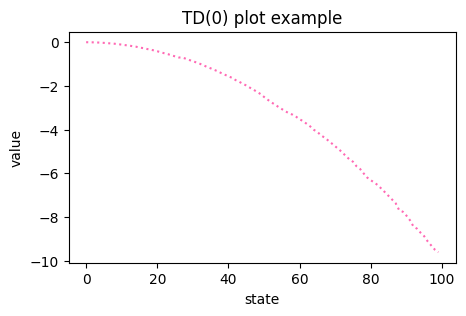

In [11]:
#TD zero plot example

pi_init = policy_aggr()

V_td_zero, track_x_t = td_zero(int(N_MAX-1), pi_init, 10e4)
print(f'min state: {min(track_x_t)}')

plot_results(V_td_zero, 'state', 'value', 'TD(0) plot example', 'hotpink')

- LSTD algorithm creation and plot example

In [33]:
# LSTD(0) algorithm

def lstd_zero(x_init, pi, feature_map, max_iter):

    #initialize
    x_t = x_init
    a_t = np.argmax(pi[x_t])
    r_t = reward_calc(x_t, a_t)
    x_tpo = next_state(x_t, a_t)
    track_x_t = []
    track_x_t.append(x_t)

    A_t = np.zeros((feature_map(x_t).shape[0], feature_map(x_t).shape[0]))
    b_t = np.zeros((feature_map(x_t).shape[0]))

    #run LSTD(0)
    for t in range(int(max_iter)):
        A_t += np.outer(feature_map(x_t), (feature_map(x_t) - GAMMA*feature_map(x_tpo)).T)
        b_t += r_t*feature_map(x_t)

        x_t = x_tpo
        a_t = np.argmax(pi[x_t])
        r_t = reward_calc(x_t, a_t)
        x_tpo = next_state(x_t, a_t)
        # track_x_t.append(x_t)

    #create theta vector
    theta = np.dot(np.linalg.pinv(A_t), b_t) #(1/int(max_iter))*

    #apply theta vector
    V = np.zeros((N_MAX))
    for x in range(N_MAX):
        V[x] = np.dot(theta.T, feature_map(x))

    return V, track_x_t


min state: 99


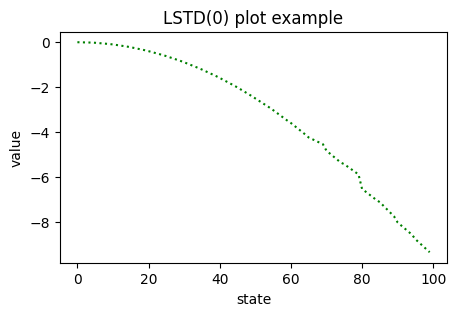

In [37]:
#lstd zero plot example

pi_init = policy_aggr()

V_lstd_zero, track_x_t = lstd_zero(int(N_MAX-1), pi_init, piecewise_feature_map, 10e5)

print(f'min state: {min(track_x_t)}')
plot_results(V_lstd_zero, 'state', 'value', 'LSTD(0) plot example', 'green')

- Track Runs

In [47]:
combs = [(policy_lazy(), fine_feature_map, 'Lazy','Fine'), (policy_aggr(), fine_feature_map, 'Aggr','Fine'),
         (policy_lazy(), coarse_feature_map, 'Lazy','Coarse'), (policy_aggr(), coarse_feature_map, 'Aggr','Coarse'),
         (policy_lazy(), piecewise_feature_map, 'Lazy','PW'), (policy_aggr(), piecewise_feature_map, 'Aggr','PW')]

In [14]:


dict_track = {}
for val in MAX_ITER_LIST:
    dict_track[val] = {}

dict_track[10] = {}
dict_track[100] = {}
dict_policy = {}
dict_policy[10] = {}
dict_policy[100] = {}


- Plot Lazy Policy value function results by
    - max_iter ($10^4, 10^5, 10^6, 10^7$)
    - method (TD(0), LSTD(0): [fine, coarse, piecewise])

0
1
2
3


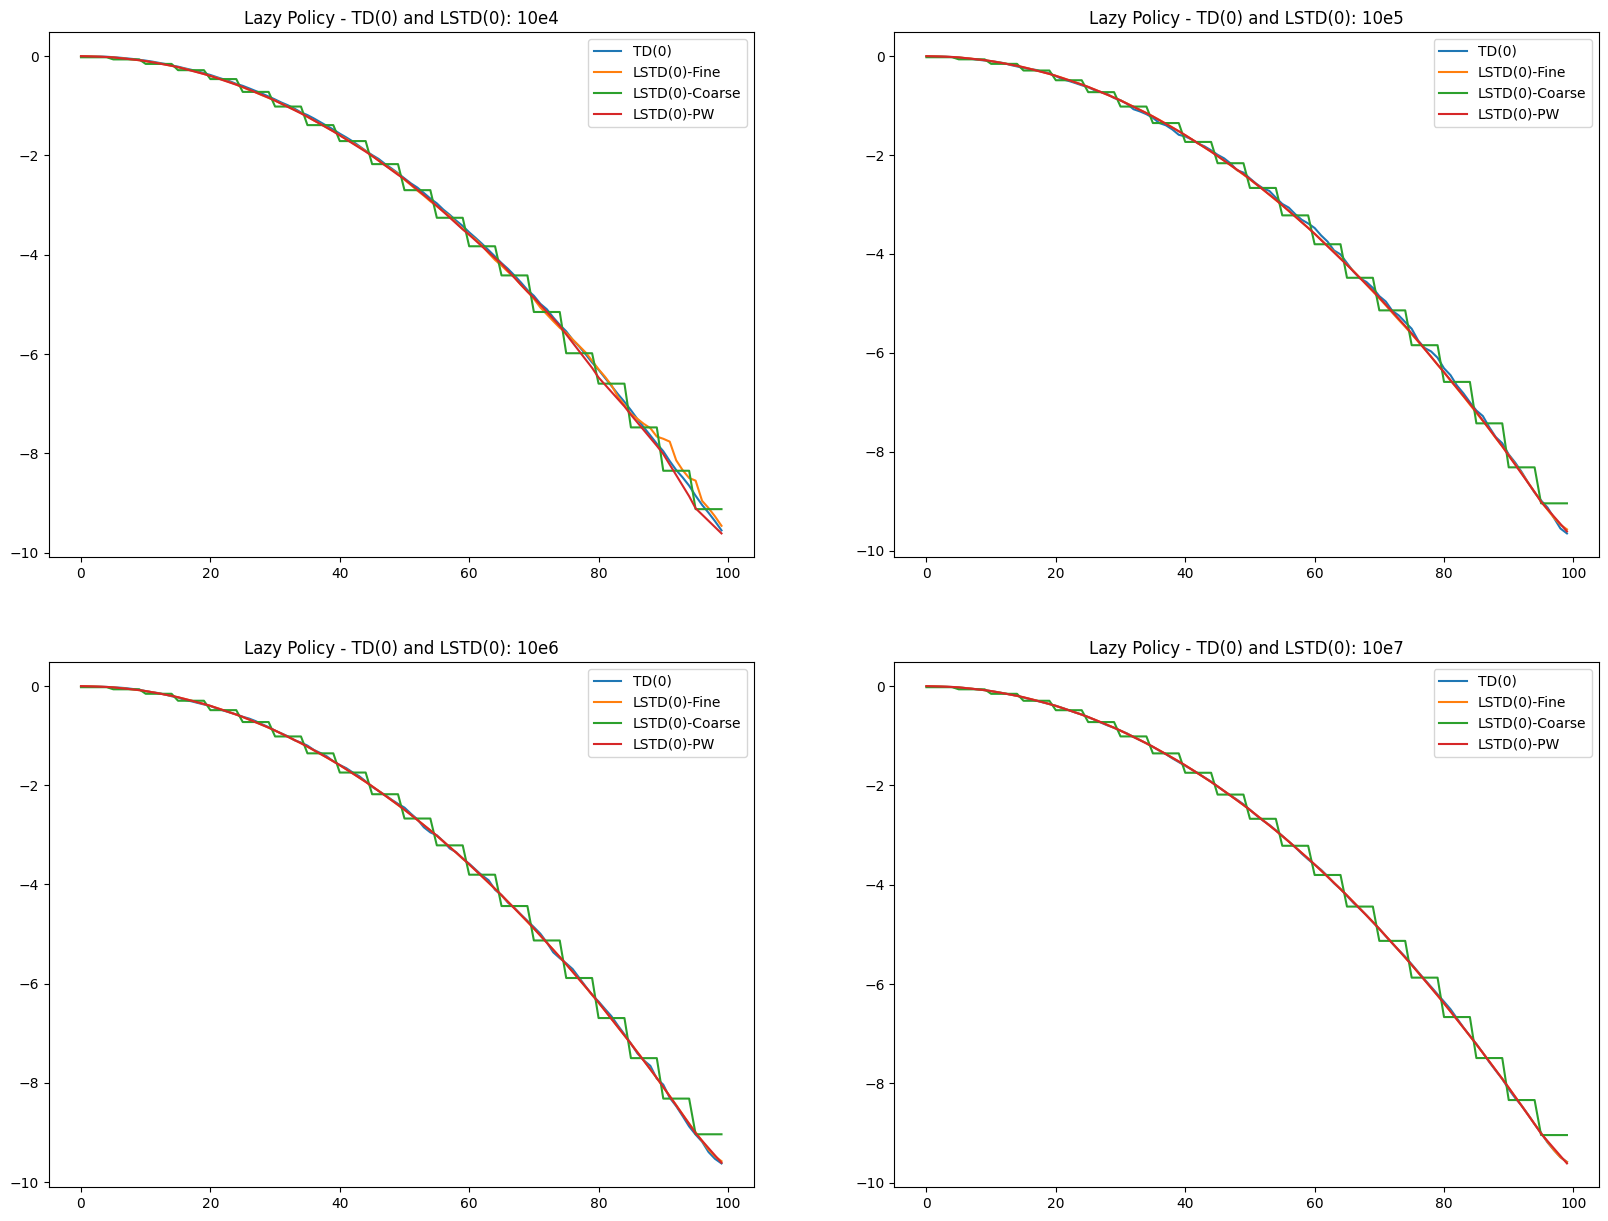

In [15]:
#Lazy Policy

policy = 'Lazy'
pi = policy_lazy()

fig, axes = plt.subplots(2, 2, figsize=(20, 15))
axes = axes.flatten()

for i, ax in enumerate(axes):
    print(i)

    V_, track_x_t = td_zero(int(N_MAX-1), pi, MAX_ITER_LIST[i])
    name = ('TD(0)', policy)
    dict_track[MAX_ITER_LIST[i]][name] = V_
    ax.plot(V_, label = 'TD(0)')

    for comb in combs:
        if comb[2] == policy:
            V_, track_x_t = lstd_zero(int(N_MAX-1), pi, comb[1], MAX_ITER_LIST[i])
            name = ('LSTD(0)', policy, comb[3])
            dict_track[MAX_ITER_LIST[i]][name] = V_
            ax.plot(V_, label = f'LSTD(0)-{comb[3]}')

    ax.title.set_text(f'{policy} Policy - TD(0) and LSTD(0): {MAX_ITER_LIST_STR[i]}')
    ax.legend()

plt.show()


- Plot Aggressive Policy value function results by
    - max_iter ($10^4, 10^5, 10^6, 10^7$)
    - method (TD(0), LSTD(0): [fine, coarse, piecewise])

0
1
2
3


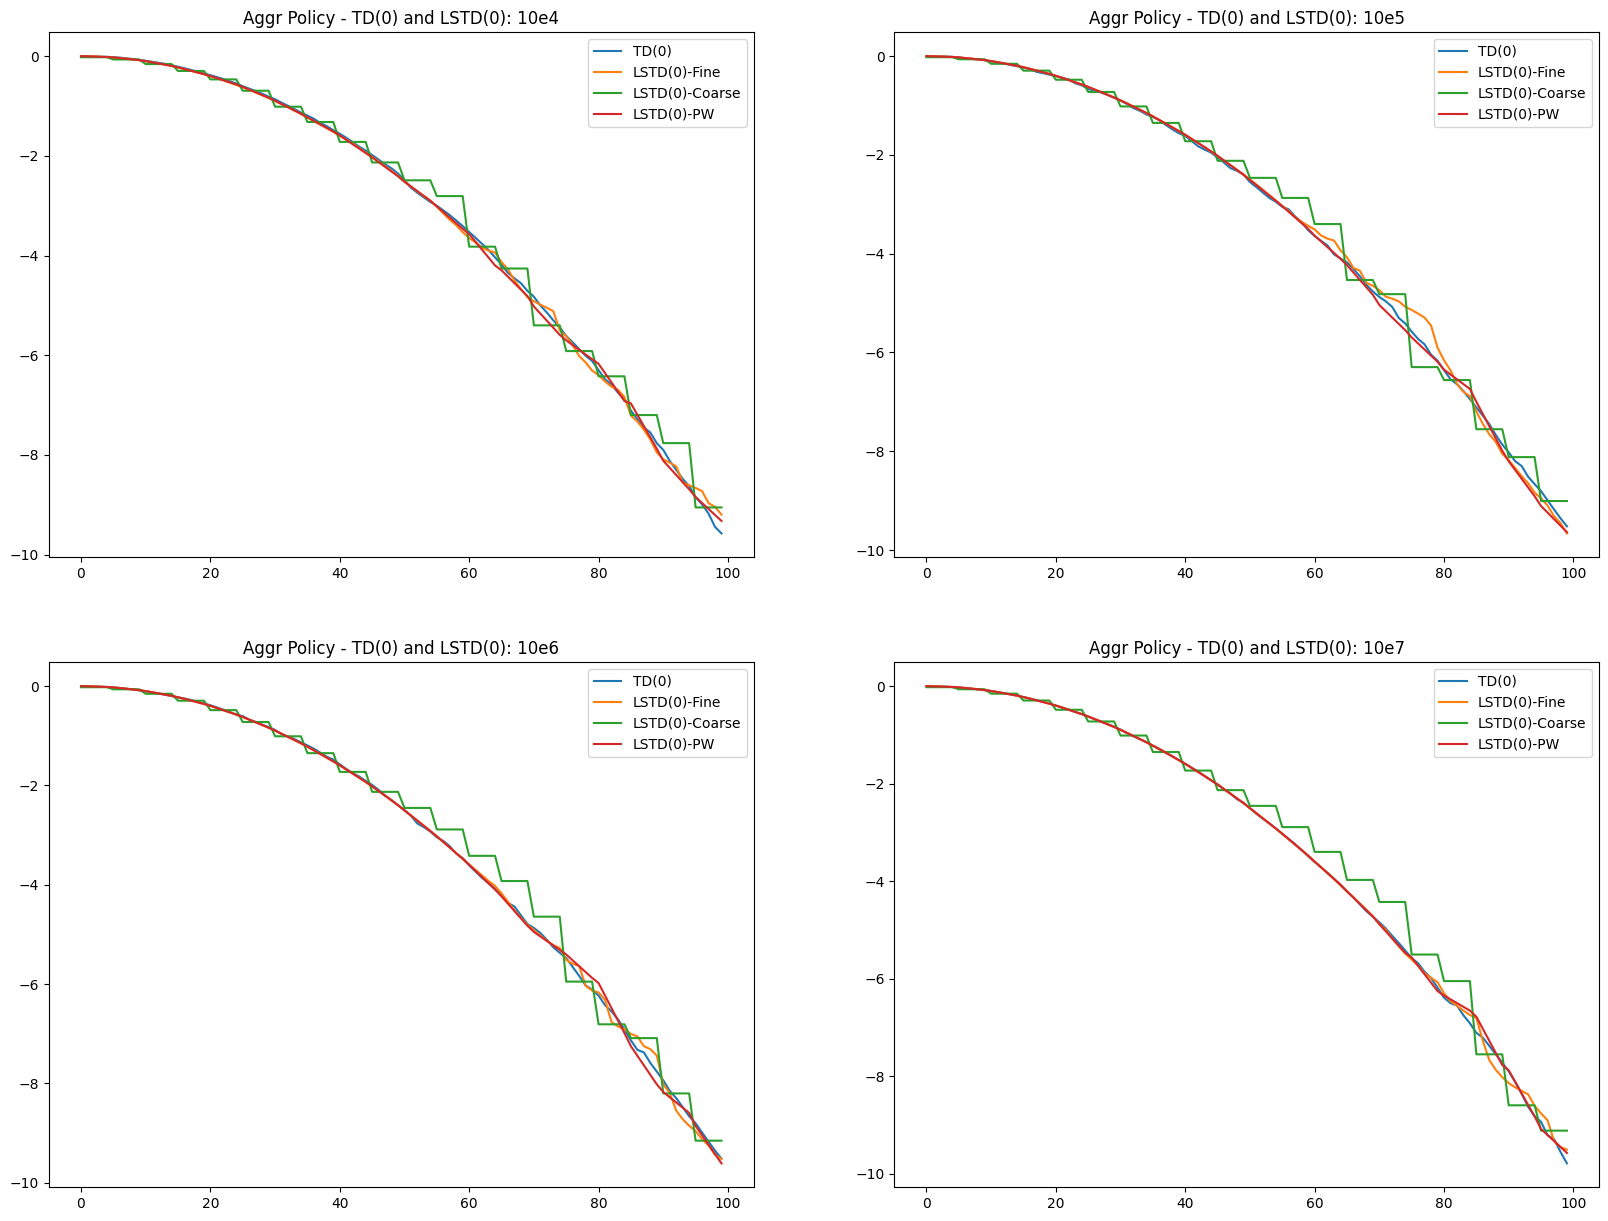

In [16]:
#Aggressive Policy

policy = 'Aggr'
pi = policy_aggr()

fig, axes = plt.subplots(2, 2, figsize=(20, 15))
axes = axes.flatten()

for i, ax in enumerate(axes):
    print(i)

    V_, track_x_t = td_zero(int(N_MAX-1), pi, MAX_ITER_LIST[i])
    name = ('TD(0)', policy)
    dict_track[MAX_ITER_LIST[i]][name] = V_
    ax.plot(V_, label = 'TD(0)')

    for comb in combs:
        if comb[2] == policy:
            V_, track_x_t = lstd_zero(int(N_MAX-1), pi, comb[1], MAX_ITER_LIST[i])
            name = ('LSTD(0)', policy, comb[3])
            dict_track[MAX_ITER_LIST[i]][name] = V_
            ax.plot(V_, label = f'LSTD(0)-{comb[3]}')

    ax.title.set_text(f'{policy} Policy - TD(0) and LSTD(0): {MAX_ITER_LIST_STR[i]}')
    ax.legend()

plt.show()

- Compare difference betweeh Lazy and Aggressive Policy value function results by
    - max_iter ($10^4, 10^5, 10^6, 10^7$)
    - method (TD(0), LSTD(0): [fine, coarse, piecewise])


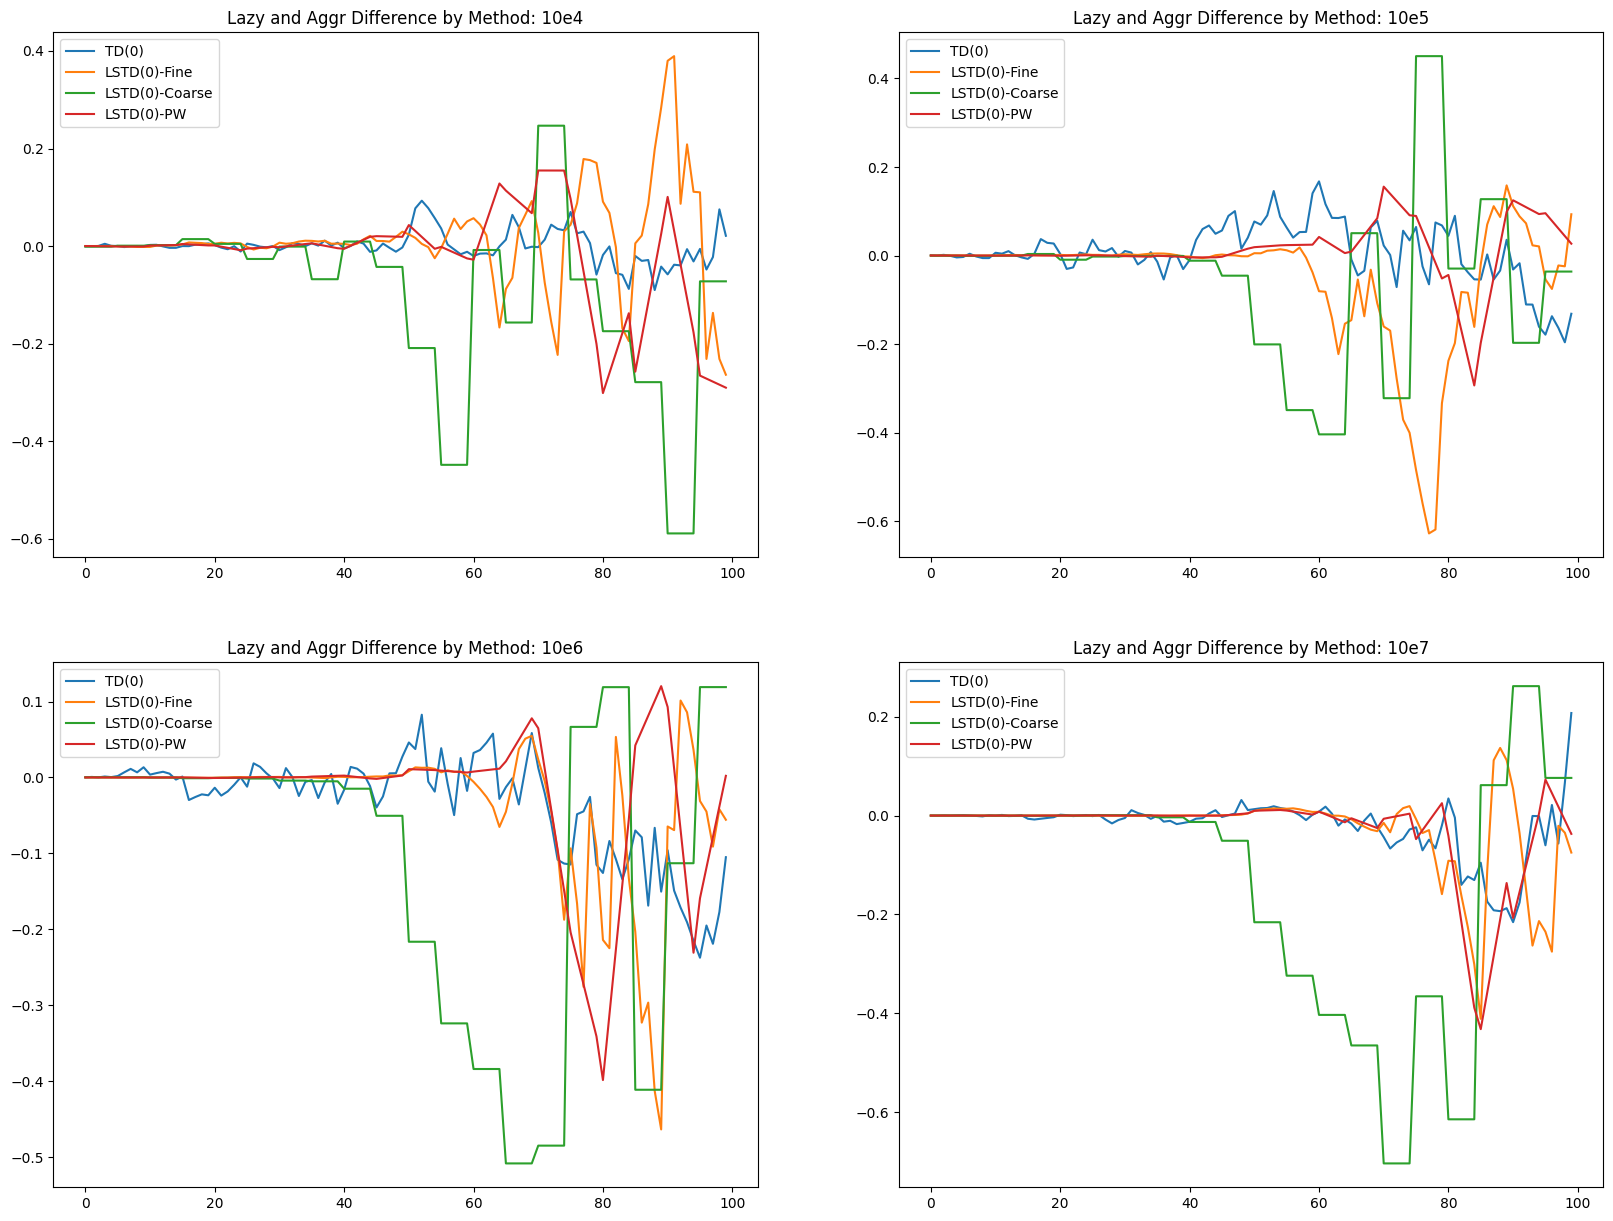

In [17]:
#Compare Lazy and Aggr value functions by method

fig, axes = plt.subplots(2, 2, figsize=(20, 15))
axes = axes.flatten()

for i, ax in enumerate(axes):

    name = ('TD(0)', policy)
    V_diff = dict_track[MAX_ITER_LIST[i]][('TD(0)', 'Lazy')] - dict_track[MAX_ITER_LIST[i]][('TD(0)', 'Aggr')]
    ax.plot(V_diff, label = 'TD(0)')

    for comb in combs:
        if comb[2] == 'Lazy':
            V_diff = dict_track[MAX_ITER_LIST[i]][('LSTD(0)', 'Lazy', comb[3])] - dict_track[MAX_ITER_LIST[i]][('LSTD(0)', 'Aggr', comb[3])]
            ax.plot(V_diff, label = f'LSTD(0)-{comb[3]}')

    ax.title.set_text(f'Lazy and Aggr Difference by Method: {MAX_ITER_LIST_STR[i]}')
    ax.legend()

plt.show()

- Compare to results from HW1 by incorporating the below into the plot
    - Value function under lazy policy
    - Value function under aggressive policy
    - Value function from policy iteration[100]

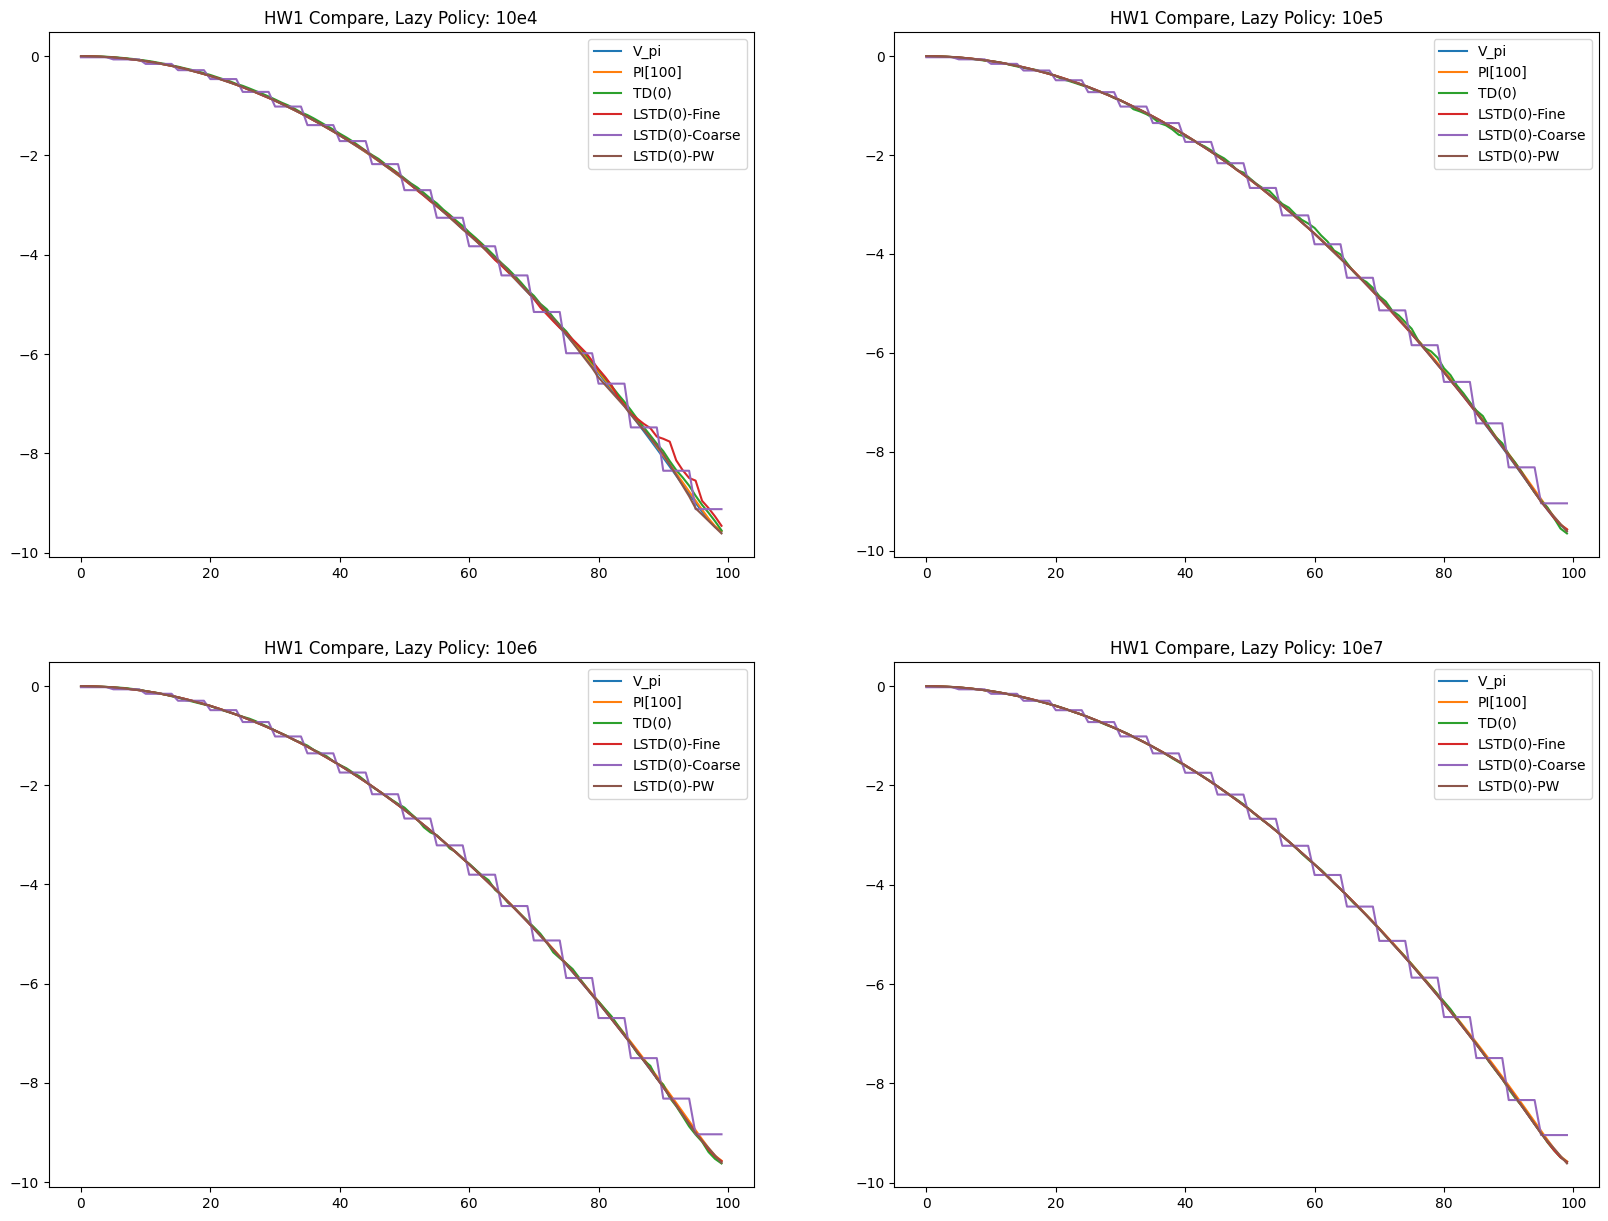

In [25]:
#Lazy Comparison to HW1

policy = 'Lazy'
pi = policy_lazy()
V_pi = value_under_policy(pi)
V_star, pi_star_policy = policy_iteration(100)

fig, axes = plt.subplots(2, 2, figsize=(20, 15))
axes = axes.flatten()

for i, ax in enumerate(axes):

    ax.plot(V_pi, label = 'V_pi')
    ax.plot(V_star, label = 'PI[100]')

    V_ = dict_track[MAX_ITER_LIST[i]][('TD(0)', policy)]
    ax.plot(V_, label = 'TD(0)')

    for comb in combs:
        if comb[2] == policy:
            V_ = dict_track[MAX_ITER_LIST[i]][('LSTD(0)', policy, comb[3])]
            ax.plot(V_, label = f'LSTD(0)-{comb[3]}')

    ax.title.set_text(f'HW1 Compare, {policy} Policy: {MAX_ITER_LIST_STR[i]}')
    ax.legend()

plt.show()

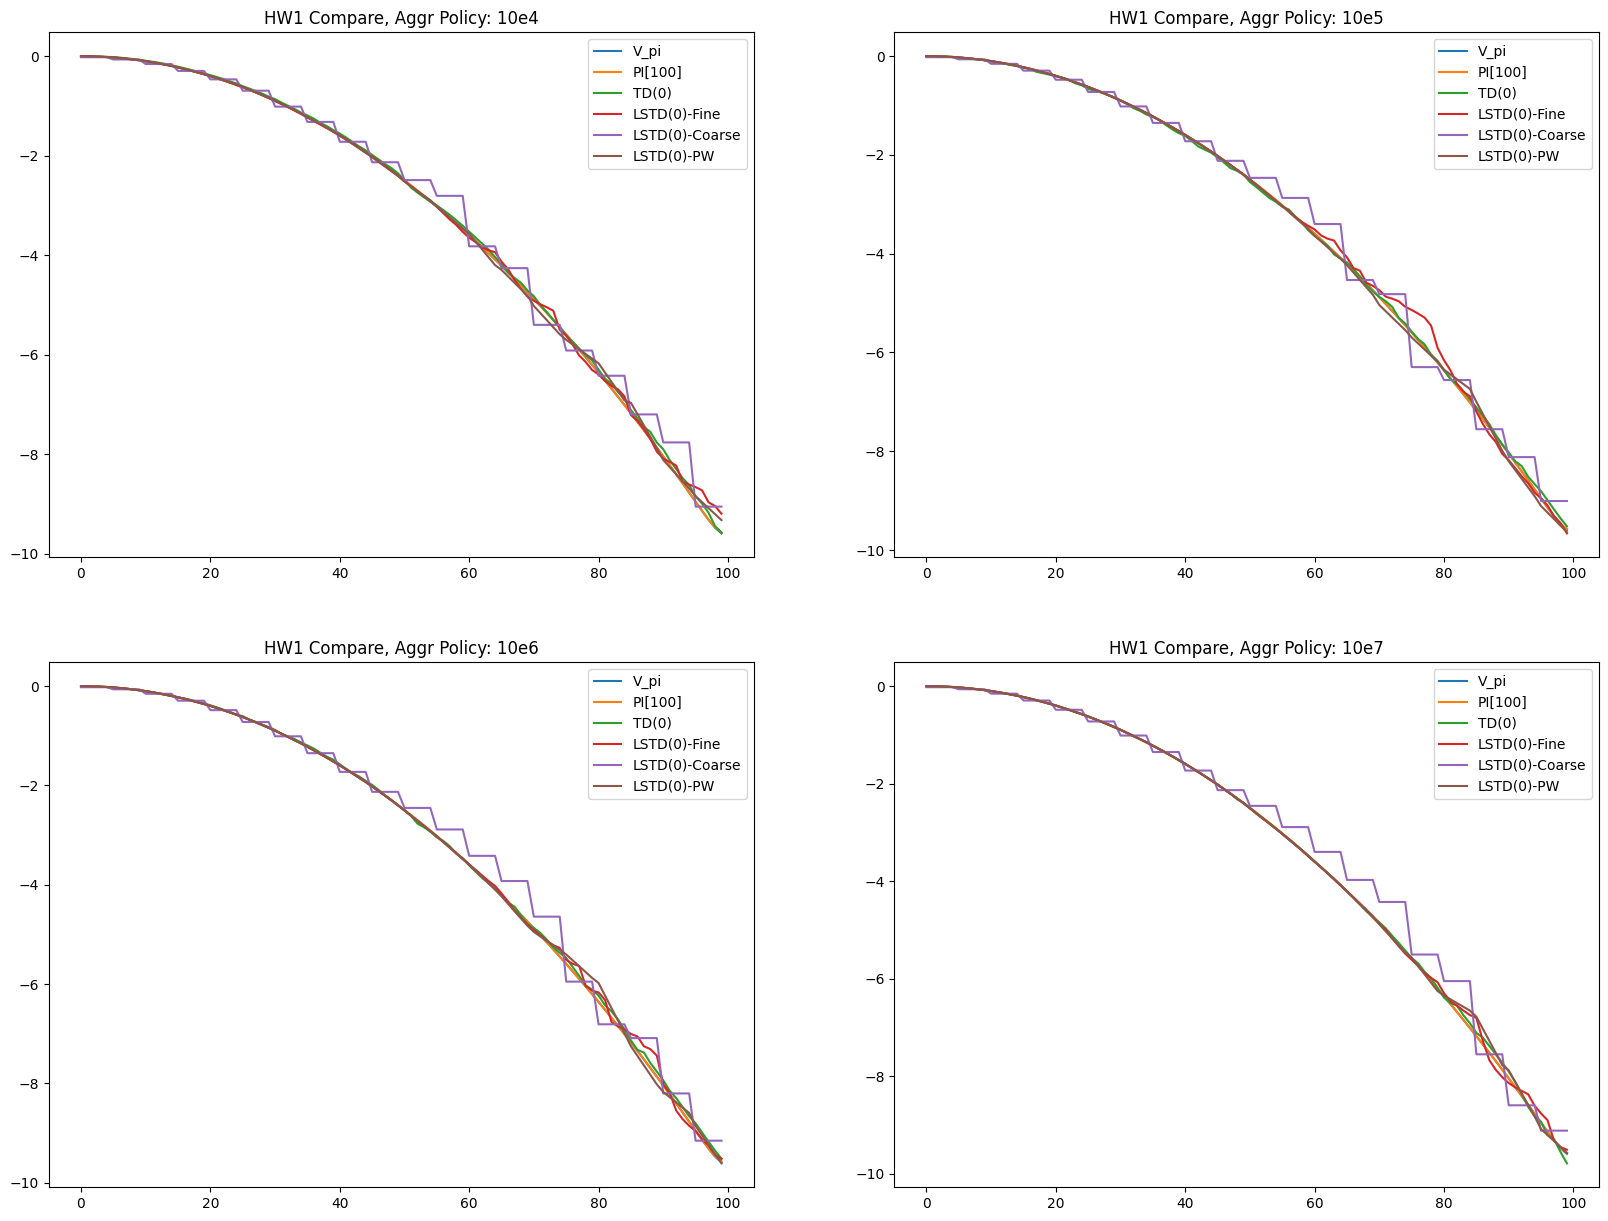

In [26]:
#Aggressive Comparison to HW1

policy = 'Aggr'
pi = policy_aggr()
V_pi = value_under_policy(pi)
V_star, pi_star_policy = policy_iteration(100)

fig, axes = plt.subplots(2, 2, figsize=(20, 15))
axes = axes.flatten()

for i, ax in enumerate(axes):

    ax.plot(V_pi, label = 'V_pi')
    ax.plot(V_star, label = 'PI[100]')

    V_ = dict_track[MAX_ITER_LIST[i]][('TD(0)', policy)]
    ax.plot(V_, label = 'TD(0)')

    for comb in combs:
        if comb[2] == policy:
            V_ = dict_track[MAX_ITER_LIST[i]][('LSTD(0)', policy, comb[3])]
            ax.plot(V_, label = f'LSTD(0)-{comb[3]}')

    ax.title.set_text(f'HW1 Compare, {policy} Policy: {MAX_ITER_LIST_STR[i]}')
    ax.legend()

plt.show()

In [24]:
# #export dictionary as JSON
# import json

# # Specify the file path where you want to save the JSON file
# file_path = 'dict_track_part1.json'

# # Write dictionary to JSON file
# with open(file_path, 'w') as f:
#     json.dump(dict_track, f, indent=4)

# import pickle 

# file_path = 'dict_track_part1.pickle'

# # Write dictionary to pickle file
# with open(file_path, 'wb') as f:
#     pickle.dump(dict_track, f)


## <a id='part2'>Part 2: Approximate Policy Iteration</a>
- **Objective**: implement an approximate policy iteration method
- **Tasks:**
  - Create approximate policy iteration method and plot example
  - Plot value function after 10 and 100 iterations
  - Compare to value function from Part1
  - Compare the value function to the optimal value function from HW1
  - Plot the service rates assigned by the final policy, interpret

In [48]:
#policy evaluation and policy improvement

def policy_evaluation(pi, feature_map):
    V_k, track_x_t = lstd_zero(int(N_MAX-1), pi, feature_map, 10e4)
    return V_k

def policy_improvement(V):

    #create Q function estimate
    Q = np.zeros((N_MAX, len(ACTION_LIST)))
    
    for x in range(N_MAX):
        for a in ACTION_LIST:
            if x == 0:
                Q[x,a] = reward_calc(x,a) + \
                        GAMMA*(1-ARRIVAL_RATE)*V[x] + \
                            GAMMA*ARRIVAL_RATE*(reduction_rate(a)*V[x] + (1-reduction_rate(a)*V[x+1]))
            elif x == int(N_MAX-1):
                Q[x,a] = reward_calc(x,a) + \
                        GAMMA*(1-ARRIVAL_RATE)*(reduction_rate(a)*V[x-1] + (1-reduction_rate(a))*V[x]) + \
                            GAMMA*ARRIVAL_RATE*V[x]
            else:
                Q[x,a] = reward_calc(x,a) + \
                        GAMMA*(1-ARRIVAL_RATE)*(reduction_rate(a)*V[x-1] + (1-reduction_rate(a))*V[x]) + \
                            GAMMA*ARRIVAL_RATE*(reduction_rate(a)*V[x] + (1-reduction_rate(a)*V[x+1]))

    #new policy is the greedy policy wrt Q
    pi_k = np.zeros((N_MAX, len(ACTION_LIST)))
    pi_k = np.argmax(Q, axis=1)

    return pi_k

def approx_policy_iteration(pi_init, feature_map, max_iter):

    #initialize pi
    pi_k = pi_init

    #policy iteration
    for k in range(max_iter):

        V_k = policy_evaluation(pi_k, feature_map)
        pi_k = policy_improvement(V_k)

    return V_k, pi_k


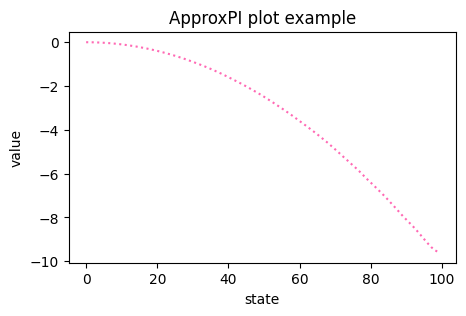

In [21]:
V_k, pi_k = approx_policy_iteration(policy_lazy(), fine_feature_map, 5)

plot_results(V_k, 'state','value','ApproxPI plot example', 'hotpink')

- Plot value function after 10 and 100 iterations

i: 10, comb: Lazy-Fine, run_time: 36.0244
i: 10, comb: Aggr-Fine, run_time: 37.291
i: 10, comb: Lazy-Coarse, run_time: 44.7301
i: 10, comb: Aggr-Coarse, run_time: 43.0313
i: 10, comb: Lazy-PW, run_time: 71.5616
i: 10, comb: Aggr-PW, run_time: 74.1605
i: 100, comb: Lazy-Fine, run_time: 361.1705
i: 100, comb: Aggr-Fine, run_time: 361.1631
i: 100, comb: Lazy-Coarse, run_time: 415.1957
i: 100, comb: Aggr-Coarse, run_time: 414.2485
i: 100, comb: Lazy-PW, run_time: 696.2103
i: 100, comb: Aggr-PW, run_time: 697.3703


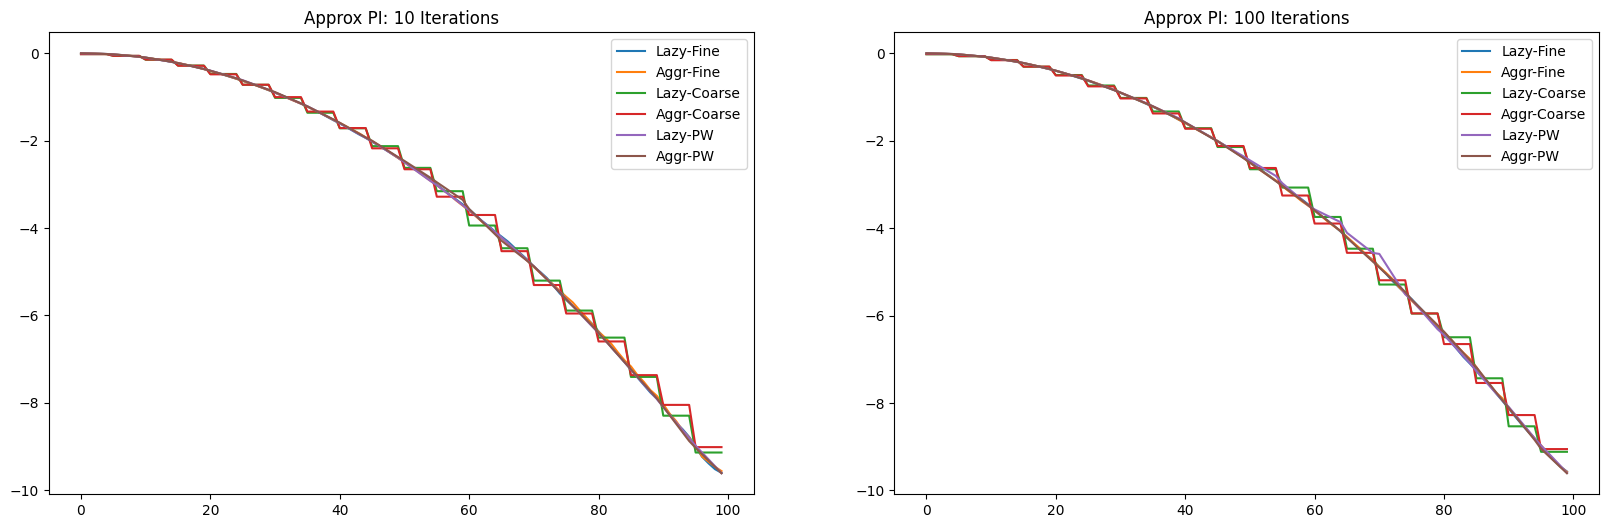

In [53]:
#Approximate PI

fig, axes = plt.subplots(1, 2, figsize=(20, 6))

for i, ax in enumerate(axes):
    if i == 0:
        for comb in combs:
            start_time = time.time()
            V_k, pi_k = approx_policy_iteration(comb[0], comb[1], 10)
            end_time = time.time()
            run_time = round(end_time - start_time,4)
            print(f'i: {10}, comb: {comb[2]}-{comb[3]}, run_time: {run_time}')
            ax.plot(V_k, label = f'{comb[2]}-{comb[3]}')
            name = ('API', comb[2], comb[3])
            dict_track[10][name] = V_k
            dict_policy[10][name] = pi_k
        ax.title.set_text(f'Approx PI: 10 Iterations')
        ax.legend()
    else:
        for comb in combs:
            start_time = time.time()
            V_k, pi_k = approx_policy_iteration(comb[0], comb[1], 100)
            end_time = time.time()
            run_time = round(end_time - start_time,4)
            print(f'i: {100}, comb: {comb[2]}-{comb[3]}, run_time: {run_time}')
            ax.plot(V_k, label = f'{comb[2]}-{comb[3]}')
            name = ('API', comb[2], comb[3])
            dict_track[100][name] = V_k
            dict_policy[100][name] = pi_k
        ax.title.set_text(f'Approx PI: 100 Iterations')
        ax.legend()

import pickle

file_path = 'dict_track_part1_and_part2.pickle'

# Write dictionary to pickle file
with open(file_path, 'wb') as f:
    pickle.dump(dict_track, f)

file_path = 'dict_policy_part2.pickle'

# Write dictionary to pickle file
with open(file_path, 'wb') as f:
    pickle.dump(dict_policy, f)

plt.show()

- Compare to value function from Part1

In [55]:
dict_track.keys()

dict_keys([100000.0, 1000000.0, 10000000.0, 100000000.0, 10, 100])

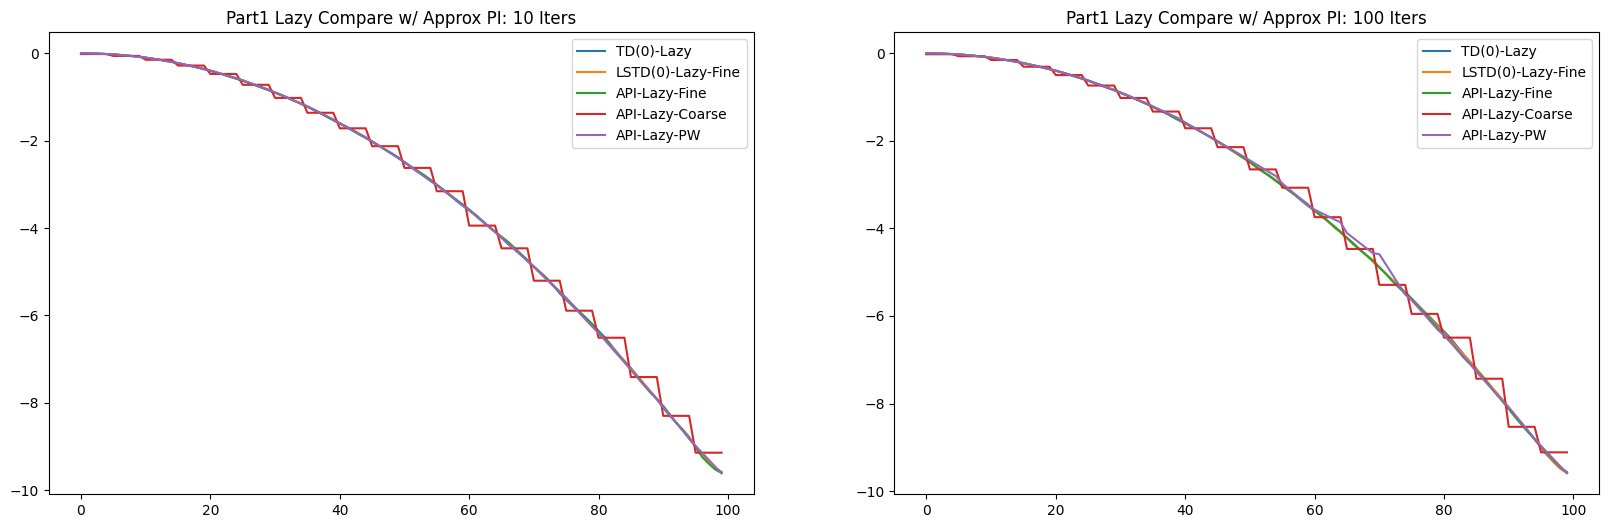

In [66]:
#Approximate PI

type = 'Lazy'
part1_ = 100000000.0

fig, axes = plt.subplots(1, 2, figsize=(20, 6))

for i, ax in enumerate(axes):
    if i == 0:
        name = ('TD(0)',type)
        ax.plot(dict_track[part1_][name], label = f'{name[0]}-{name[1]}')

        name = ('LSTD(0)', type, 'Fine')
        ax.plot(dict_track[part1_][name], label = f'{name[0]}-{name[1]}-{name[2]}')

        for comb in combs:
            if (comb[2]==type):
                name = ('API', comb[2], comb[3])
                ax.plot(dict_track[10][name], label = f'API-{comb[2]}-{comb[3]}')
        ax.title.set_text(f'Part1 {type} Compare w/ Approx PI: 10 Iters')
        ax.legend()
    else:
        name = ('TD(0)',type)
        ax.plot(dict_track[part1_][name], label = f'{name[0]}-{name[1]}')

        name = ('LSTD(0)', type, 'Fine')
        ax.plot(dict_track[part1_][name], label = f'{name[0]}-{name[1]}-{name[2]}')

        for comb in combs:
            if (comb[2]==type):
                name = ('API', comb[2], comb[3])
                ax.plot(dict_track[100][name], label = f'API-{comb[2]}-{comb[3]}')
        ax.title.set_text(f'Part1 {type} Compare w/ Approx PI: 100 Iters')
        ax.legend()

plt.show()

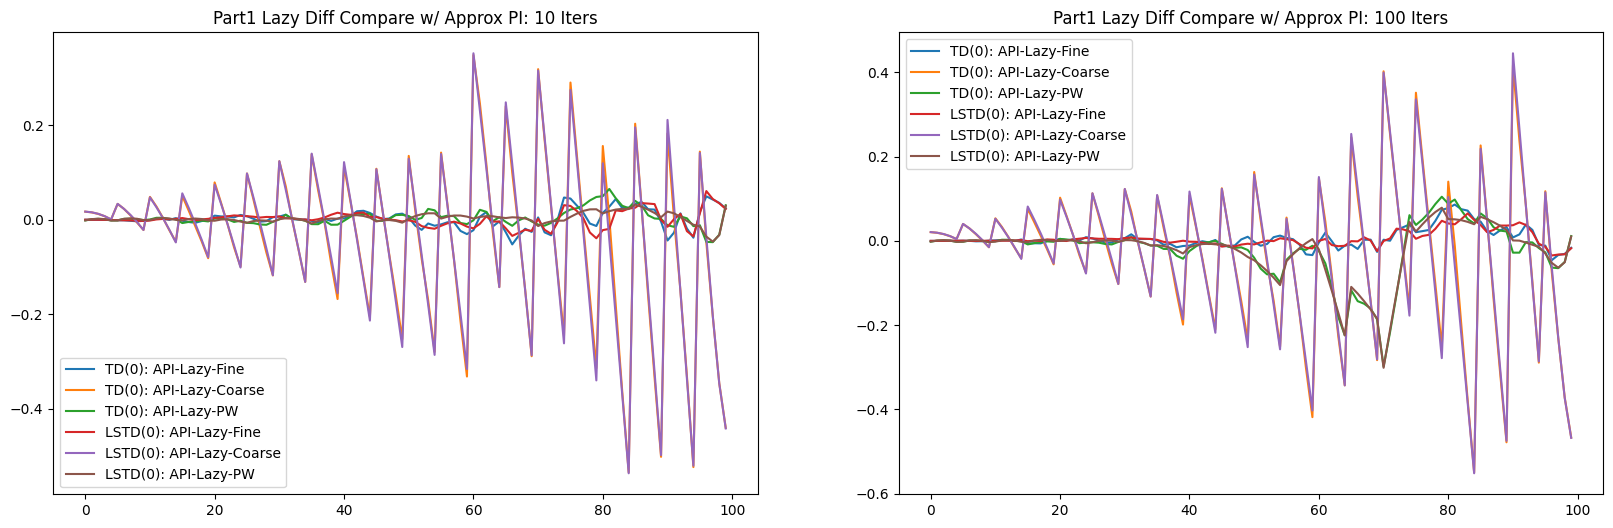

In [72]:
type = 'Lazy'
part1_ = 100000000.0

fig, axes = plt.subplots(1, 2, figsize=(20, 6))

for i, ax in enumerate(axes):
    if i == 0:

        method = 'TD(0)'
        name = (method,type)
        V_comp = dict_track[part1_][name]

        for comb in combs:
            if (comb[2]==type):
                name = ('API', comb[2], comb[3])
                V_diff = V_comp - dict_track[10][name]
                ax.plot(V_diff, label = f'{method}: API-{comb[2]}-{comb[3]}')

        method = 'LSTD(0)'
        name = (method,type,'Fine')
        V_comp = dict_track[part1_][name]

        for comb in combs:
            if (comb[2]==type):
                name = ('API', comb[2], comb[3])
                V_diff = V_comp - dict_track[10][name]
                ax.plot(V_diff, label = f'{method}: API-{comb[2]}-{comb[3]}')
        ax.title.set_text(f'Part1 {type} Diff Compare w/ Approx PI: 10 Iters')
        ax.legend()
    else:
        method = 'TD(0)'
        name = (method,type)
        V_comp = dict_track[part1_][name]

        for comb in combs:
            if (comb[2]==type):
                name = ('API', comb[2], comb[3])
                V_diff = V_comp - dict_track[100][name]
                ax.plot(V_diff, label = f'{method}: API-{comb[2]}-{comb[3]}')

        method = 'LSTD(0)'
        name = (method,type,'Fine')
        V_comp = dict_track[part1_][name]

        for comb in combs:
            if (comb[2]==type):
                name = ('API', comb[2], comb[3])
                V_diff = V_comp - dict_track[100][name]
                ax.plot(V_diff, label = f'{method}: API-{comb[2]}-{comb[3]}')
        ax.title.set_text(f'Part1 {type} Diff Compare w/ Approx PI: 100 Iters')
        ax.legend()

plt.show()

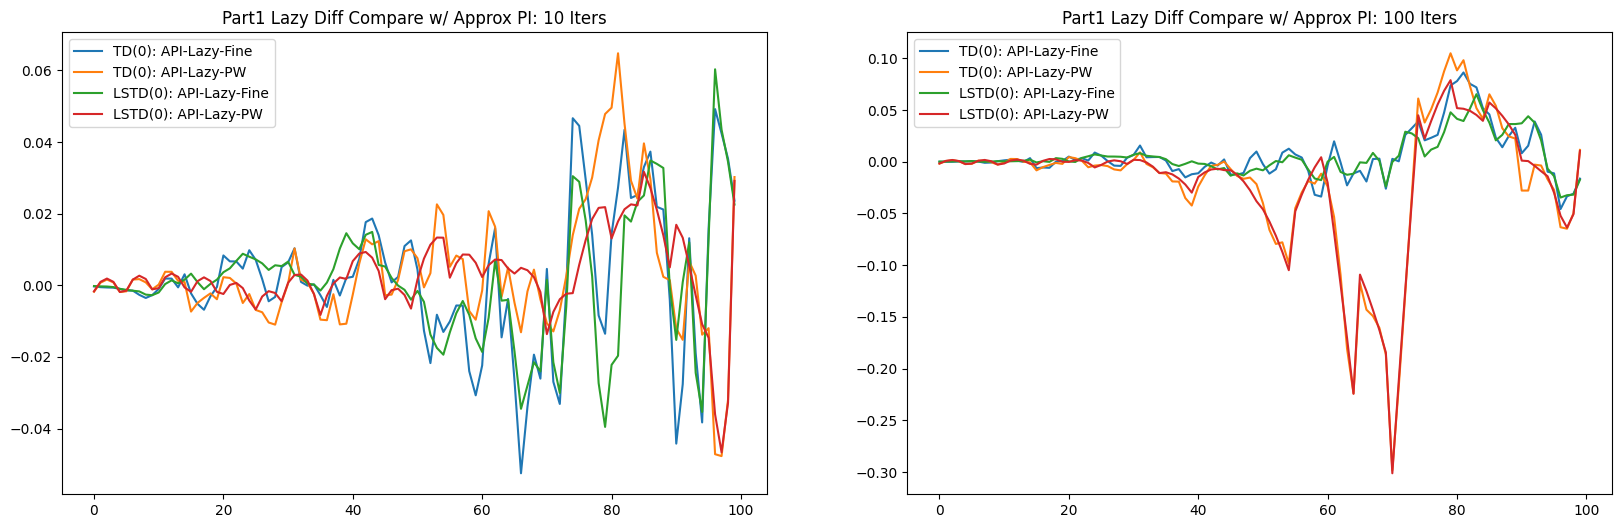

In [73]:
type = 'Lazy'
part1_ = 100000000.0

fig, axes = plt.subplots(1, 2, figsize=(20, 6))

for i, ax in enumerate(axes):
    if i == 0:

        method = 'TD(0)'
        name = (method,type)
        V_comp = dict_track[part1_][name]

        for comb in combs:
            if (comb[2]==type)&(comb[3]!='Coarse'):
                name = ('API', comb[2], comb[3])
                V_diff = V_comp - dict_track[10][name]
                ax.plot(V_diff, label = f'{method}: API-{comb[2]}-{comb[3]}')

        method = 'LSTD(0)'
        name = (method,type,'Fine')
        V_comp = dict_track[part1_][name]

        for comb in combs:
            if (comb[2]==type)&(comb[3]!='Coarse'):
                name = ('API', comb[2], comb[3])
                V_diff = V_comp - dict_track[10][name]
                ax.plot(V_diff, label = f'{method}: API-{comb[2]}-{comb[3]}')
        ax.title.set_text(f'Part1 {type} Diff Compare w/ Approx PI: 10 Iters')
        ax.legend()
    else:
        method = 'TD(0)'
        name = (method,type)
        V_comp = dict_track[part1_][name]

        for comb in combs:
            if (comb[2]==type)&(comb[3]!='Coarse'):
                name = ('API', comb[2], comb[3])
                V_diff = V_comp - dict_track[100][name]
                ax.plot(V_diff, label = f'{method}: API-{comb[2]}-{comb[3]}')

        method = 'LSTD(0)'
        name = (method,type,'Fine')
        V_comp = dict_track[part1_][name]

        for comb in combs:
            if (comb[2]==type)&(comb[3]!='Coarse'):
                name = ('API', comb[2], comb[3])
                V_diff = V_comp - dict_track[100][name]
                ax.plot(V_diff, label = f'{method}: API-{comb[2]}-{comb[3]}')
        ax.title.set_text(f'Part1 {type} Diff Compare w/ Approx PI: 100 Iters')
        ax.legend()

plt.show()

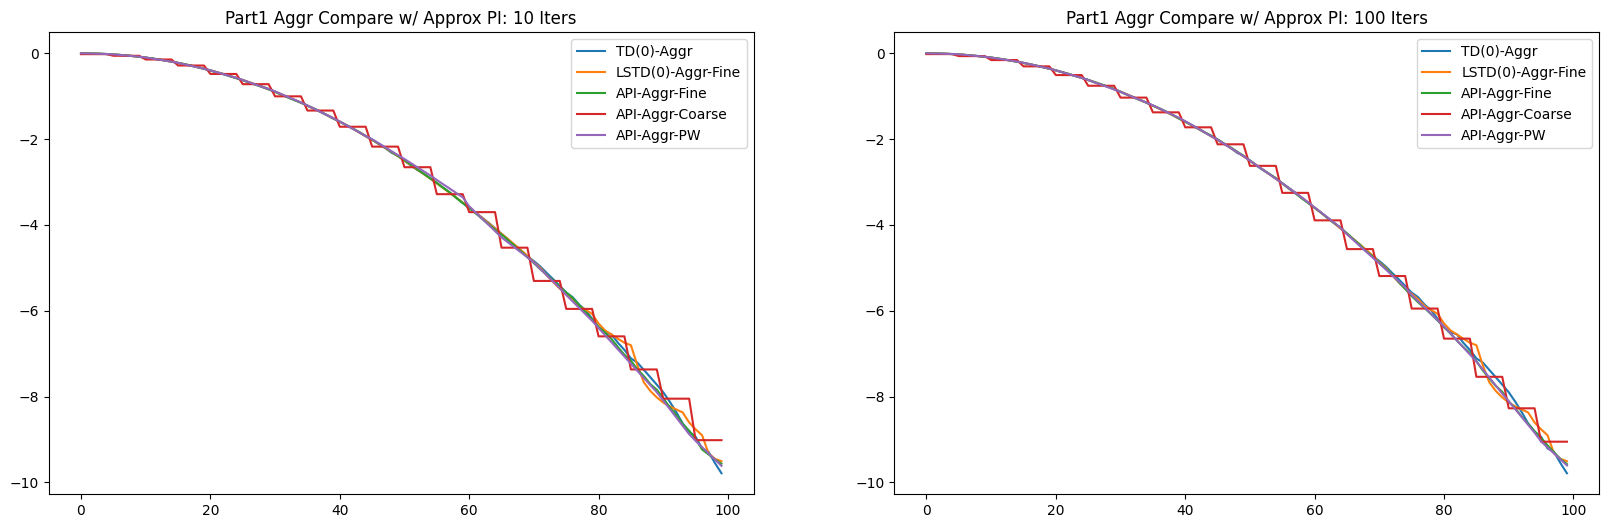

In [67]:
type = 'Aggr'
part1_ = 100000000.0

fig, axes = plt.subplots(1, 2, figsize=(20, 6))

for i, ax in enumerate(axes):
    if i == 0:
        name = ('TD(0)',type)
        ax.plot(dict_track[part1_][name], label = f'{name[0]}-{name[1]}')

        name = ('LSTD(0)', type, 'Fine')
        ax.plot(dict_track[part1_][name], label = f'{name[0]}-{name[1]}-{name[2]}')

        for comb in combs:
            if (comb[2]==type):
                name = ('API', comb[2], comb[3])
                ax.plot(dict_track[10][name], label = f'API-{comb[2]}-{comb[3]}')
        ax.title.set_text(f'Part1 {type} Compare w/ Approx PI: 10 Iters')
        ax.legend()
    else:
        name = ('TD(0)',type)
        ax.plot(dict_track[part1_][name], label = f'{name[0]}-{name[1]}')

        name = ('LSTD(0)', type, 'Fine')
        ax.plot(dict_track[part1_][name], label = f'{name[0]}-{name[1]}-{name[2]}')

        for comb in combs:
            if (comb[2]==type):
                name = ('API', comb[2], comb[3])
                ax.plot(dict_track[100][name], label = f'API-{comb[2]}-{comb[3]}')
        ax.title.set_text(f'Part1 {type} Compare w/ Approx PI: 100 Iters')
        ax.legend()

plt.show()

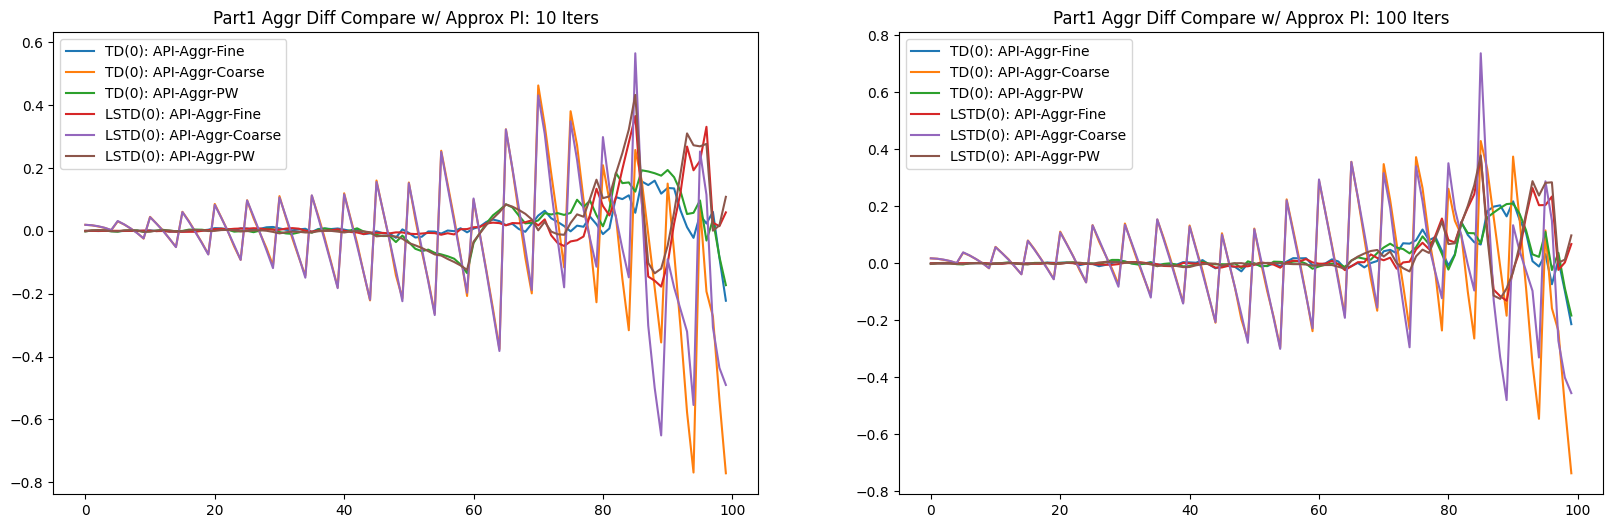

In [74]:
type = 'Aggr'
part1_ = 100000000.0

fig, axes = plt.subplots(1, 2, figsize=(20, 6))

for i, ax in enumerate(axes):
    if i == 0:

        method = 'TD(0)'
        name = (method,type)
        V_comp = dict_track[part1_][name]

        for comb in combs:
            if (comb[2]==type):
                name = ('API', comb[2], comb[3])
                V_diff = V_comp - dict_track[10][name]
                ax.plot(V_diff, label = f'{method}: API-{comb[2]}-{comb[3]}')

        method = 'LSTD(0)'
        name = (method,type,'Fine')
        V_comp = dict_track[part1_][name]

        for comb in combs:
            if (comb[2]==type):
                name = ('API', comb[2], comb[3])
                V_diff = V_comp - dict_track[10][name]
                ax.plot(V_diff, label = f'{method}: API-{comb[2]}-{comb[3]}')
        ax.title.set_text(f'Part1 {type} Diff Compare w/ Approx PI: 10 Iters')
        ax.legend()
    else:
        method = 'TD(0)'
        name = (method,type)
        V_comp = dict_track[part1_][name]

        for comb in combs:
            if (comb[2]==type):
                name = ('API', comb[2], comb[3])
                V_diff = V_comp - dict_track[100][name]
                ax.plot(V_diff, label = f'{method}: API-{comb[2]}-{comb[3]}')

        method = 'LSTD(0)'
        name = (method,type,'Fine')
        V_comp = dict_track[part1_][name]

        for comb in combs:
            if (comb[2]==type):
                name = ('API', comb[2], comb[3])
                V_diff = V_comp - dict_track[100][name]
                ax.plot(V_diff, label = f'{method}: API-{comb[2]}-{comb[3]}')
        ax.title.set_text(f'Part1 {type} Diff Compare w/ Approx PI: 100 Iters')
        ax.legend()

plt.show()

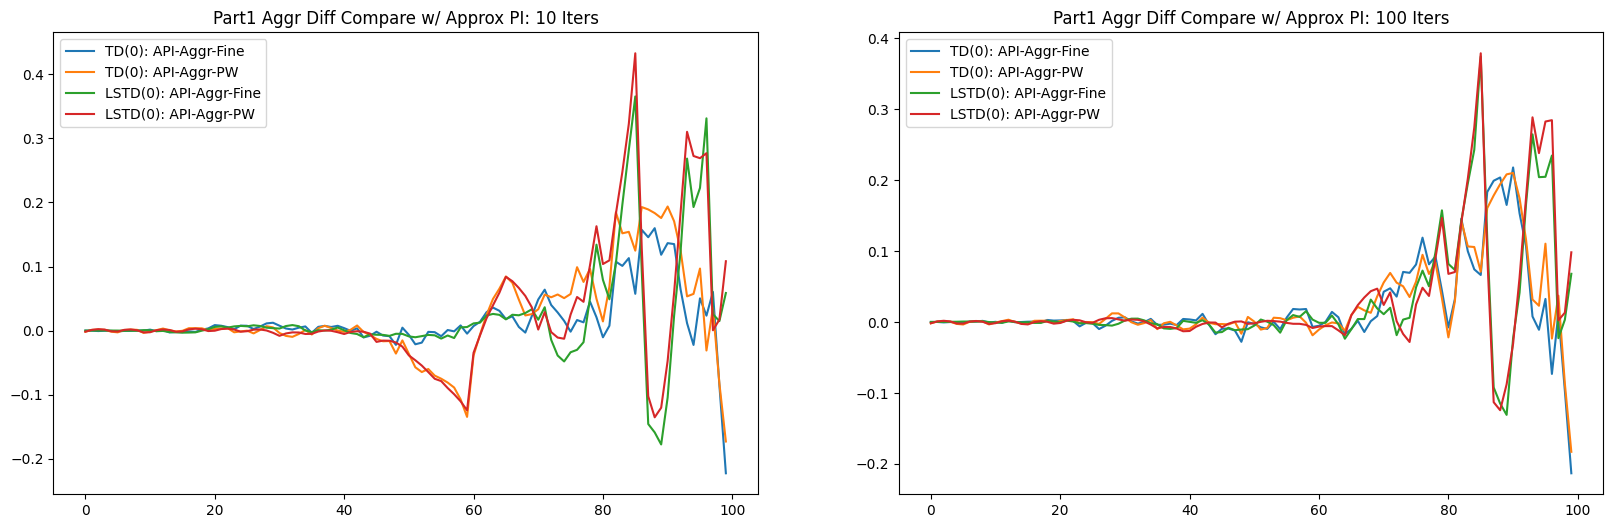

In [75]:
type = 'Aggr'
part1_ = 100000000.0

fig, axes = plt.subplots(1, 2, figsize=(20, 6))

for i, ax in enumerate(axes):
    if i == 0:

        method = 'TD(0)'
        name = (method,type)
        V_comp = dict_track[part1_][name]

        for comb in combs:
            if (comb[2]==type)&(comb[3]!='Coarse'):
                name = ('API', comb[2], comb[3])
                V_diff = V_comp - dict_track[10][name]
                ax.plot(V_diff, label = f'{method}: API-{comb[2]}-{comb[3]}')

        method = 'LSTD(0)'
        name = (method,type,'Fine')
        V_comp = dict_track[part1_][name]

        for comb in combs:
            if (comb[2]==type)&(comb[3]!='Coarse'):
                name = ('API', comb[2], comb[3])
                V_diff = V_comp - dict_track[10][name]
                ax.plot(V_diff, label = f'{method}: API-{comb[2]}-{comb[3]}')
        ax.title.set_text(f'Part1 {type} Diff Compare w/ Approx PI: 10 Iters')
        ax.legend()
    else:
        method = 'TD(0)'
        name = (method,type)
        V_comp = dict_track[part1_][name]

        for comb in combs:
            if (comb[2]==type)&(comb[3]!='Coarse'):
                name = ('API', comb[2], comb[3])
                V_diff = V_comp - dict_track[100][name]
                ax.plot(V_diff, label = f'{method}: API-{comb[2]}-{comb[3]}')

        method = 'LSTD(0)'
        name = (method,type,'Fine')
        V_comp = dict_track[part1_][name]

        for comb in combs:
            if (comb[2]==type)&(comb[3]!='Coarse'):
                name = ('API', comb[2], comb[3])
                V_diff = V_comp - dict_track[100][name]
                ax.plot(V_diff, label = f'{method}: API-{comb[2]}-{comb[3]}')
        ax.title.set_text(f'Part1 {type} Diff Compare w/ Approx PI: 100 Iters')
        ax.legend()

plt.show()

- Compare the value function to the optimal value function from HW1

Looking at the difference between the value function tied to the optimal policy iteration solution from HW1 we see a clear difference when using the coarse feature map. Between using 10 or 100 iterations, we see more differences between all the methods at just 10 iterations than an 100 where all methods converge to the same solution at 100 iterations. We see the strongest value differences occur at points where the queue is longer.

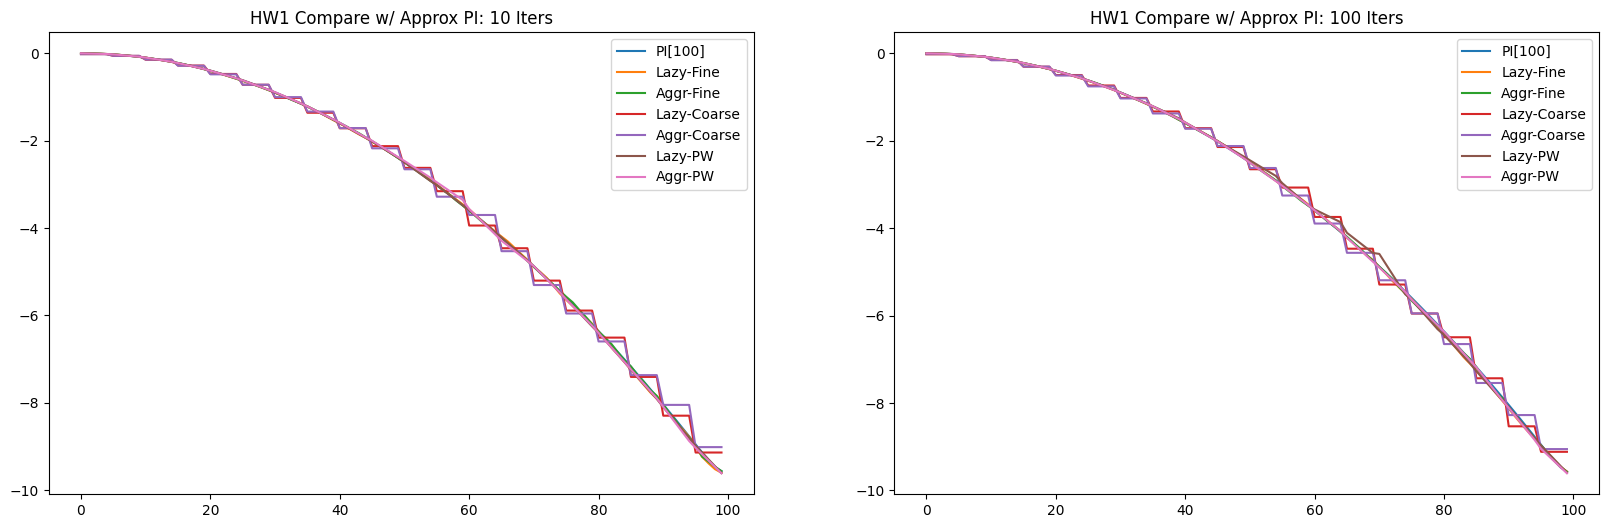

In [59]:
#Approximate PI

fig, axes = plt.subplots(1, 2, figsize=(20, 6))

for i, ax in enumerate(axes):
    if i == 0:
        ax.plot(V_star, label = 'PI[100]')

        for comb in combs:
            name = ('API', comb[2], comb[3])
            ax.plot(dict_track[10][name], label = f'{comb[2]}-{comb[3]}')
        ax.title.set_text(f'HW1 Compare w/ Approx PI: 10 Iters')
        ax.legend()
    else:
        ax.plot(V_star, label = 'PI[100]')

        for comb in combs:
            name = ('API', comb[2], comb[3])
            ax.plot(dict_track[100][name], label = f'{comb[2]}-{comb[3]}')
        ax.title.set_text(f'HW1 Compare w/ Approx PI: 100 Iters')
        ax.legend()

plt.show()

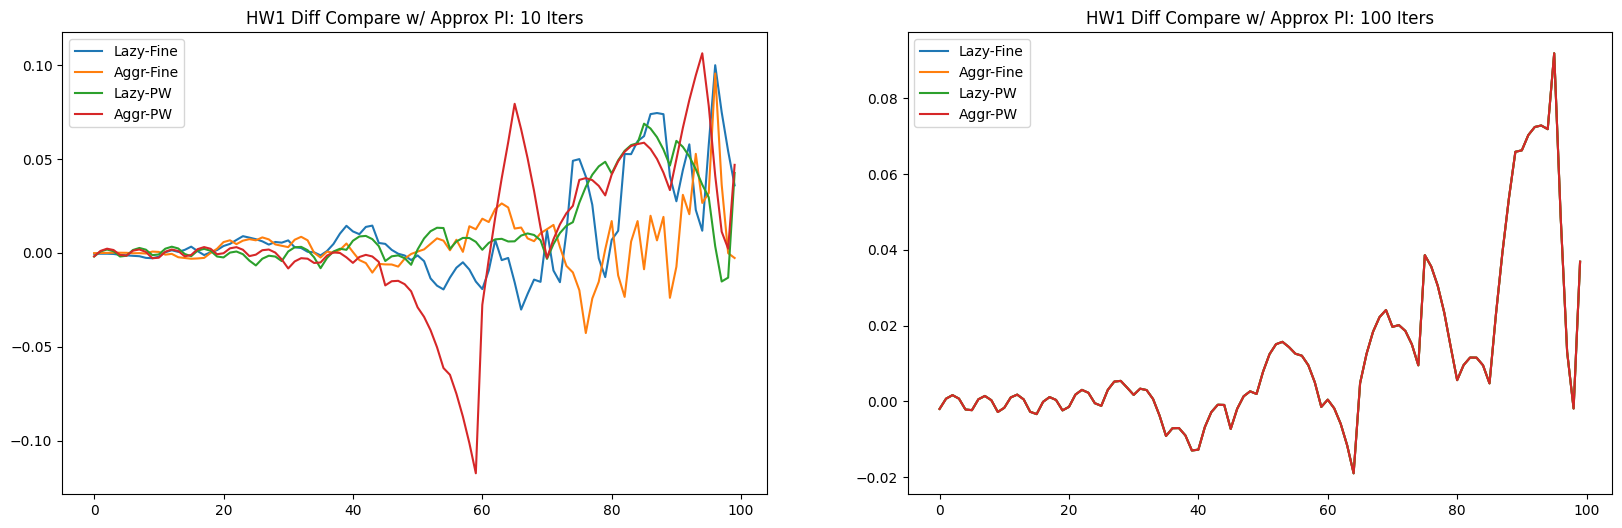

In [65]:

fig, axes = plt.subplots(1, 2, figsize=(20, 6))

for i, ax in enumerate(axes):
    if i == 0:
        # ax.plot(V_star, label = 'PI[100]')

        for comb in combs:
            if comb[3] != 'Coarse':
                name = ('API', comb[2], comb[3])
                V_diff = V_star - dict_track[10][name]
                ax.plot(V_diff, label = f'{comb[2]}-{comb[3]}')
        ax.title.set_text(f'HW1 Diff Compare w/ Approx PI: 10 Iters')
        ax.legend()
    else:
        # ax.plot(V_star, label = 'PI[100]')

        for comb in combs:
            if comb[3] != 'Coarse':
                V_diff = V_star - dict_track[100][name]
                ax.plot(V_diff, label = f'{comb[2]}-{comb[3]}')
        ax.title.set_text(f'HW1 Diff Compare w/ Approx PI: 100 Iters')
        ax.legend()

plt.show()

- Plot the service rates assigned by the final policy, interpret

When it comes to the final policy, regardless of initially starting with the lazy policy or aggressive policy, we see that the fine feature map and piecewise feature map end up giving more similar policy results to each other whereas the coarse feature map is just all over the place. This makes more sense given that the feature map is less representative of the range of values than the other two feature maps. We see that the feature map doesn't quite converge to the same policy across all methods when comparing the fine and piecewise policies using Lazy as the initial policy or Aggr as the initial policy.

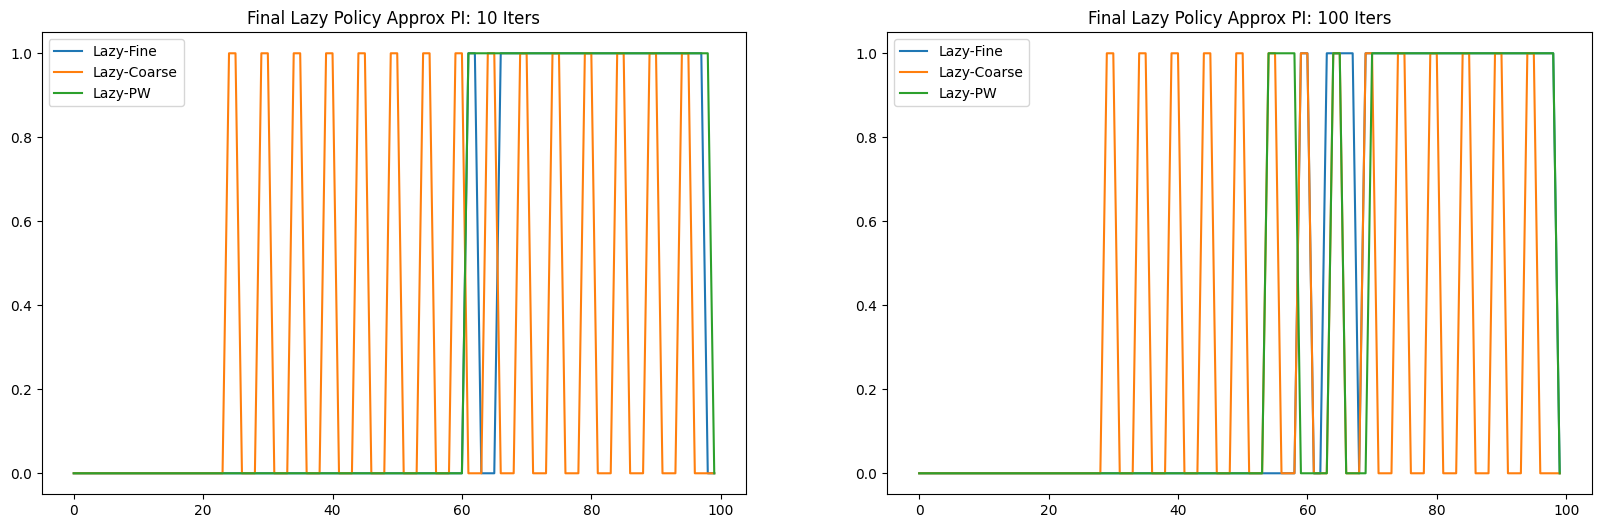

In [61]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

type = 'Lazy'

for i, ax in enumerate(axes):
    if i == 0:
        # ax.plot(policy_lazy(), label = 'PI[100]')

        for comb in combs:
            if comb[2] == type:
                name = ('API', comb[2], comb[3])
                ax.plot(dict_policy[10][name], label = f'{comb[2]}-{comb[3]}')
        ax.title.set_text(f'Final {type} Policy Approx PI: 10 Iters')
        ax.legend()
    else:
        # ax.plot(V_star, label = 'PI[100]')

        for comb in combs:
            if comb[2] == type:
                name = ('API', comb[2], comb[3])
                ax.plot(dict_policy[100][name], label = f'{comb[2]}-{comb[3]}')
        ax.title.set_text(f'Final {type} Policy Approx PI: 100 Iters')
        ax.legend()

plt.show()

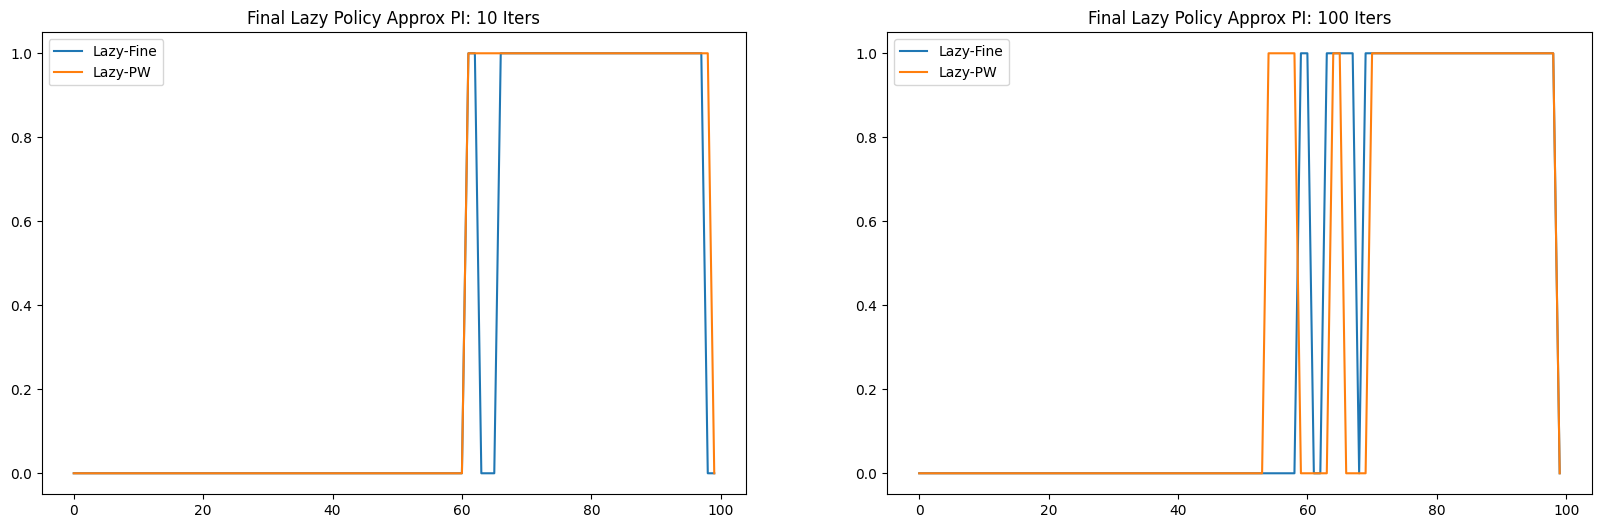

In [63]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

type = 'Lazy'

for i, ax in enumerate(axes):
    if i == 0:
        # ax.plot(policy_lazy(), label = 'PI[100]')

        for comb in combs:
            if (comb[2] == type) & (comb[3] != 'Coarse'):
                name = ('API', comb[2], comb[3])
                ax.plot(dict_policy[10][name], label = f'{comb[2]}-{comb[3]}')
        ax.title.set_text(f'Final {type} Policy Approx PI: 10 Iters')
        ax.legend()
    else:
        # ax.plot(V_star, label = 'PI[100]')

        for comb in combs:
            if (comb[2] == type) & (comb[3] != 'Coarse'):
                name = ('API', comb[2], comb[3])
                ax.plot(dict_policy[100][name], label = f'{comb[2]}-{comb[3]}')
        ax.title.set_text(f'Final {type} Policy Approx PI: 100 Iters')
        ax.legend()

plt.show()

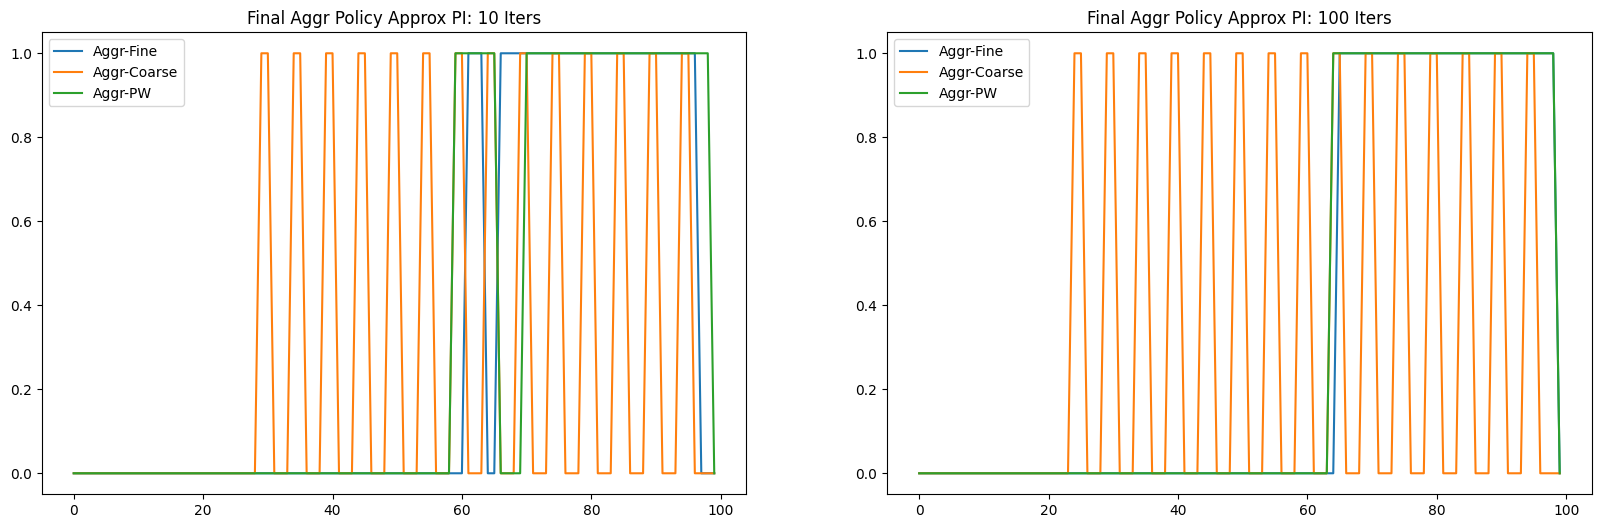

In [62]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

type = 'Aggr'

for i, ax in enumerate(axes):
    if i == 0:
        # ax.plot(policy_lazy(), label = 'PI[100]')

        for comb in combs:
            if comb[2] == type:
                name = ('API', comb[2], comb[3])
                ax.plot(dict_policy[10][name], label = f'{comb[2]}-{comb[3]}')
        ax.title.set_text(f'Final {type} Policy Approx PI: 10 Iters')
        ax.legend()
    else:
        # ax.plot(V_star, label = 'PI[100]')

        for comb in combs:
            if comb[2] == type:
                name = ('API', comb[2], comb[3])
                ax.plot(dict_policy[100][name], label = f'{comb[2]}-{comb[3]}')
        ax.title.set_text(f'Final {type} Policy Approx PI: 100 Iters')
        ax.legend()

plt.show()

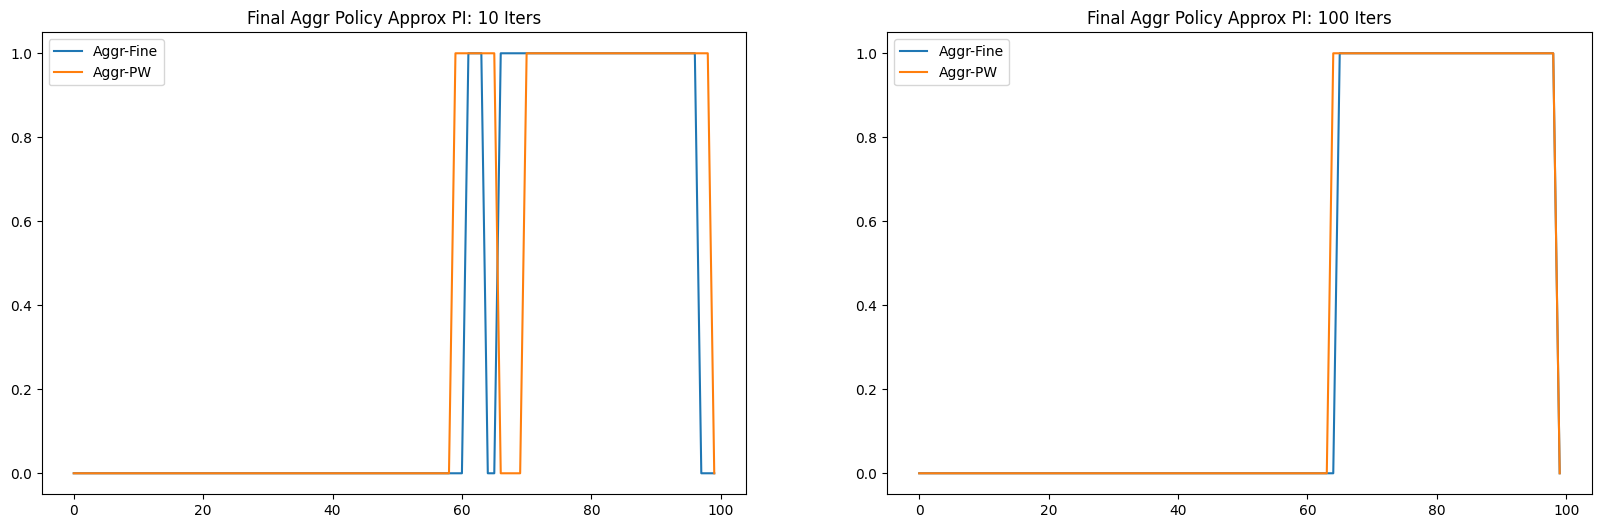

In [64]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

type = 'Aggr'

for i, ax in enumerate(axes):
    if i == 0:
        # ax.plot(policy_lazy(), label = 'PI[100]')

        for comb in combs:
            if (comb[2] == type) & (comb[3] != 'Coarse'):
                name = ('API', comb[2], comb[3])
                ax.plot(dict_policy[10][name], label = f'{comb[2]}-{comb[3]}')
        ax.title.set_text(f'Final {type} Policy Approx PI: 10 Iters')
        ax.legend()
    else:
        # ax.plot(V_star, label = 'PI[100]')

        for comb in combs:
            if (comb[2] == type) & (comb[3] != 'Coarse'):
                name = ('API', comb[2], comb[3])
                ax.plot(dict_policy[100][name], label = f'{comb[2]}-{comb[3]}')
        ax.title.set_text(f'Final {type} Policy Approx PI: 100 Iters')
        ax.legend()

plt.show()